# K-Nearest Neighbors (KNN) Implementation Take #2

Importing Necessary Packages 

In [ ]:
import os 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import linkage, dendrogram
import geopandas as gpd
import textwrap
from matplotlib.patches import ConnectionPatch
from scipy.spatial import Voronoi



Reading in key datasets

In [2]:
#Reading in the data
os.chdir(r"C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\4_Data_Modeling\4.2_KNN_Clustering")
df = pd.read_csv(r"C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\0_Datasets\1.7Master_Files\Individual Year Files_Take2\merged_2023.csv")
distgrad = pd.read_csv(r"C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\0_Datasets\1.6Data2023\District\clean_data\distgrad_2023_clean.csv")
distprof = pd.read_csv(r"C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\0_Datasets\1.6Data2023\District\clean_data\distprof_2023_clean.csv")


Importing demographic buckets from other .py file (lists containing relevant columns to run algorithm on) 

In [ ]:
os.chdir(r"C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\4_Data_Modeling\4.2_KNN_Clustering")
from Demographic_Buckets import class_size_student_teacher_ratios
from Demographic_Buckets import student_mobility
from Demographic_Buckets import staff_demographics_experience
from Demographic_Buckets import race_ethnicity_percent
from Demographic_Buckets import economic_special_needs_percent
from Demographic_Buckets import language_education_percent
from Demographic_Buckets import gender_distribution_percent
from Demographic_Buckets import grade_level_percent
from Demographic_Buckets import special_populations_percent
from Demographic_Buckets import gifted_title1_percent
from Demographic_Buckets import district_identifiers

Importing functions from the .py file (containing all functions used for this analysis)

In [ ]:
from KNN_Functions import calculate_missing_percentage


# Looking at the Bucketed Demographic Columns

In [73]:
df = df[df['Charter School (Y/N)'] == 'N']
demographic_df = df[class_size_student_teacher_ratios + student_mobility + staff_demographics_experience + race_ethnicity_percent +
                    economic_special_needs_percent + language_education_percent + gender_distribution_percent + grade_level_percent +
                    special_populations_percent + district_identifiers]

Text(0.5, 1.0, 'Histogram of percentage of NA values in columns within demographic attributes')

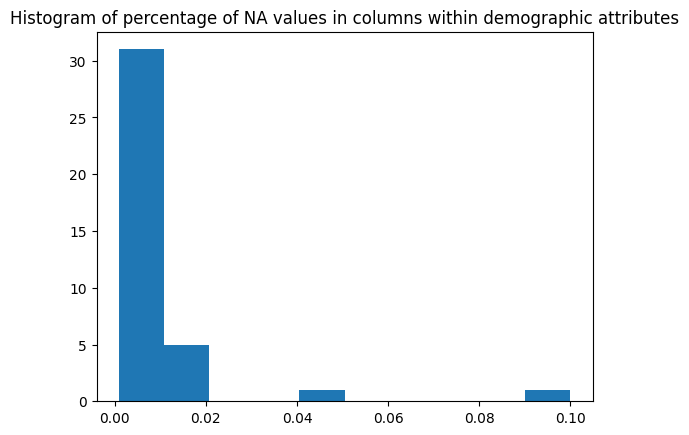

In [ ]:
plt.hist(calculate_missing_percentage(demographic_df) / 100)
plt.title("Histogram of percentage of NA values in columns within demographic attributes")

Takeaway: Pretty solid in terms of missing values. Not many to be found, the columns not shown on the histogram are complete with 0 NAs 

Key takaways, the demographic data contains very few columns with a lot of NAs! The outcome oriented data on the other hand varies slightly. Regardless, the data science portion (fitting a knn model) will occur on mostly complete data

# Step 3: Data Modeling: 


In [ ]:
from KNN_Functions import find_nearest_districts
from KNN_Functions import plot_texas_districts
from KNN_Functions import 

selected_features = race_ethnicity_percent + economic_special_needs_percent + grade_level_percent + special_populations_percent
knn_model = find_nearest_districts(df, 101912)
plot_texas_districts


Helper function visualizing how close neighbors are to selected value. 

In [ ]:
from KNN_Functions import find_nearest_districts
from KNN_Functions import plot_texas_districts
from KNN_Functions import plot_race_ethnicity_stacked_bar

selected_features = race_ethnicity_percent + economic_special_needs_percent + grade_level_percent + special_populations_percent
knn_model = find_nearest_districts(df, 101912, selected_features)
plot_texas_districts(knn_model, df)
plot_race_ethnicity_stacked_bar(knn_model, df)

ImportError: cannot import name 'find_nearest_districts' from 'KNN_Functions' (C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\4_Data_Modeling\4.2_KNN_Clustering\KNN_Functions.py)

In [ ]:
def find_nearest_districts(df, district_id, feature_buckets, n_neighbors=5, impute_strategy="median"):
    """
    Finds the nearest neighboring districts using K-Nearest Neighbors (KNN) based on selected demographic features.

    Parameters:
        df (pd.DataFrame): The dataset containing school district data.
        district_id (int or str): The ID of the district for which to find similar districts.
        feature_buckets (list): List of feature columns to be used for similarity comparison.
        n_neighbors (int, optional): Number of nearest neighbors to find (default is 5).
        impute_strategy (str, optional): Strategy for handling missing values, options include 
                                         'mean', 'median', 'most_frequent', or 'constant' (default is "median").

    Returns:
        list: A list of district IDs corresponding to the nearest neighboring districts.

    Raises:
        ValueError: If the specified district_id is not found in the dataset.

    Process:
        1. Filters the dataset to include only the relevant feature columns.
        2. Handles missing values in the selected feature columns using the specified imputation strategy.
        3. Standardizes (normalizes) the feature values to ensure consistent distance calculations.
        4. Fits a K-Nearest Neighbors (KNN) model using Euclidean distance as the similarity metric.
        5. Identifies the closest districts to the specified district_id based on the trained KNN model.
        6. Returns the list of nearest district IDs.

    Example Usage:
        ```python
        nearest_districts = find_nearest_districts(df, district_id=1023, 
                                                   feature_buckets=["Student_Teacher_Ratio", "Econ_Disadv_Percent"],
                                                   n_neighbors=5, impute_strategy="mean")
        print(nearest_districts)
        ```
    """
    # Step 1: Filter dataset for selected features
    existing_columns = [col for col in feature_buckets if col in df.columns]
    
    # Select only available columns
    knn_df = df[["DISTRICT_id"] + existing_columns].copy()
    
    # Step 2: Handle missing values
    imputer = SimpleImputer(strategy=impute_strategy)
    knn_df[existing_columns] = imputer.fit_transform(knn_df[existing_columns])
    
    # Step 3: Normalize the feature set
    scaler = StandardScaler()
    knn_df[existing_columns] = scaler.fit_transform(knn_df[existing_columns])
    
    # Step 4: Fit KNN model (excluding DISTRICT_id)
    knn_model = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean")
    knn_model.fit(knn_df[existing_columns])
    
    # Step 5: Find the nearest neighbors for the specified district
    query_point = knn_df[knn_df["DISTRICT_id"] == district_id][existing_columns]
    if query_point.empty:
        raise ValueError(f"District ID {district_id} not found in dataset.")
    
    distances, indices = knn_model.kneighbors(query_point)
    
    # Step 6: Get the closest districts
    nearest_districts = knn_df.iloc[indices[0]]["DISTRICT_id"].tolist()

    return nearest_districts


In [82]:
selected_features = race_ethnicity_percent + economic_special_needs_percent + grade_level_percent + special_populations_percent

knn = find_nearest_districts(df, 101912, selected_features)
knn

[101912, 57905, 220905, 171901, 101902]

Diagnostic Plot #1: Visualizing where the neighbors are 

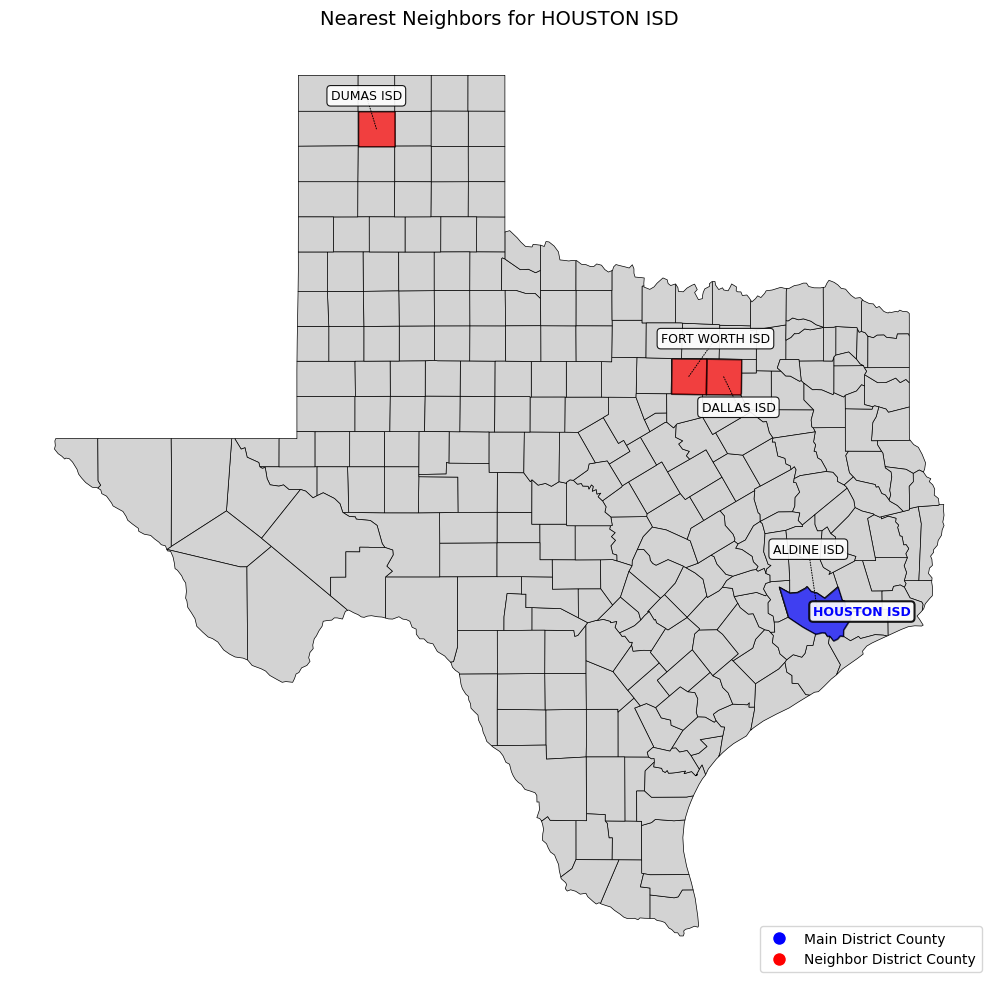

In [ ]:
def plot_texas_districts(district_ids, df):
    """
    Plots selected school districts on a Texas map based on district IDs, with intelligent
    label placement to prevent overlap regardless of location density.
    
    Parameters:
    - district_ids (list): List of district IDs to plot. The first district is the main focus.
    - df (pd.DataFrame): DataFrame containing 'DISTRICT_id', 'DISTNAME', and 'CNTYNAME' columns.
    
    Returns:
    - A map plot of Texas highlighting the selected school districts with smart non-overlapping labels.
    """
    
    if not district_ids:
        print("No district IDs provided.")
        return

    # Step 1: Filter the DataFrame to get district info
    selected_districts = df[df['DISTRICT_id'].isin(district_ids)][["DISTRICT_id", "DISTNAME", "CNTYNAME"]]
    
    if selected_districts.empty:
        print("No matching districts found. Check the district IDs.")
        return
        
    # Get the main district name (first in the list)
    main_district_info = df[df['DISTRICT_id'] == district_ids[0]]
    if main_district_info.empty:
        main_district_name = "Unknown District"
    else:
        main_district_name = main_district_info.iloc[0]["DISTNAME"]

    # Step 2: Load Texas counties shapefile
    shapefile_url = "https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_county_20m.zip"
    texas_counties = gpd.read_file(shapefile_url)

    # Step 3: Filter for Texas counties only (STATEFP = '48' for Texas)
    texas_counties = texas_counties[texas_counties["STATEFP"] == "48"]

    # Step 4: Extract county names from selected districts
    county_to_districts = selected_districts.groupby("CNTYNAME")["DISTNAME"].apply(list).to_dict()

    # Step 5: Select only the target counties from the full Texas dataset
    selected_counties = texas_counties[texas_counties["NAME"].str.upper().isin(county_to_districts.keys())]

    # Step 6: Plot the Texas map
    fig, ax = plt.subplots(figsize=(12, 10))
    texas_counties.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.5)  # All counties

    # Highlight the counties - main district's county in blue, others in red
    main_county = df[df['DISTRICT_id'] == district_ids[0]]["CNTYNAME"].iloc[0]
    
    for county_name, district_list in county_to_districts.items():
        county = selected_counties[selected_counties["NAME"].str.upper() == county_name]
        if not county.empty:
            color = "blue" if county_name == main_county else "red"
            county.plot(ax=ax, color=color, edgecolor="black", linewidth=1, alpha=0.7)

    # Step 7: Smart label placement system
    county_centroids = {}  # Store county centroids
    all_district_data = []  # Store all district data for processing
    
    # First, collect all county centroids and district information
    for row in selected_counties.itertuples():
        county_name = row.NAME.upper()
        if county_name in county_to_districts:
            centroid = row.geometry.centroid
            county_centroids[county_name] = (centroid.x, centroid.y)
            
            districts = county_to_districts[county_name]
            for district_name in districts:
                is_main = district_name == main_district_name
                all_district_data.append({
                    'county': county_name,
                    'district': district_name,
                    'centroid_x': centroid.x,
                    'centroid_y': centroid.y,
                    'is_main': is_main
                })
    
    # Convert to DataFrame for easier manipulation
    district_df = pd.DataFrame(all_district_data)
    
    # Analyze spatial density of county centroids
    if len(county_centroids) >= 3:  # Need at least 3 points for Voronoi
        points = np.array(list(county_centroids.values()))
        
        # Try to use Voronoi to analyze spatial relationships
        try:
            vor = Voronoi(points)
            # Calculate the average distance between neighboring points
            distances = []
            for i in range(len(points)):
                for j in range(i+1, len(points)):
                    dist = np.sqrt(np.sum((points[i] - points[j])**2))
                    distances.append(dist)
            
            if distances:
                avg_distance = np.mean(distances)
                density_factor = 1.0 / (avg_distance + 1e-10)  # Avoid division by zero
            else:
                density_factor = 1.0
        except:
            # Fallback if Voronoi fails
            density_factor = 1.0
    else:
        density_factor = 1.0
    
    # Adaptive spacing based on point density
    base_spacing = 2.0
    county_districts_count = district_df.groupby('county').size()
    
    # Calculate the number of districts per county and identify crowded counties
    crowded_counties = county_districts_count[county_districts_count > 1].index.tolist()
    
    # Function to intelligently place labels with adaptive spacing
    def get_label_position(row, all_positions, attempt=0, max_attempts=10):
        """Intelligently determine label position using adaptive spacing based on spatial density."""
        x, y = row['centroid_x'], row['centroid_y']
        county = row['county']
        
        # Adjust spacing based on:
        # 1. If county is crowded (has multiple districts)
        # 2. General spatial density of all counties
        # 3. Number of placement attempts so far
        
        is_crowded = county in crowded_counties
        crowd_factor = 1.5 if is_crowded else 1.0
        attempt_factor = 1.0 + (attempt * 0.2)  # Increase radius with each attempt
        
        # Adaptive radius calculation
        radius = base_spacing * density_factor * crowd_factor * attempt_factor
        
        # Strategic angle calculation - spread points apart
        angle_base = (hash(row['district']) % 36) * 10  # Pseudorandom starting angle based on district name
        angle_offset = attempt * 30  # Rotate by 30 degrees with each attempt
        angle = (angle_base + angle_offset) % 360
        angle_rad = np.radians(angle)
        
        # Calculate position
        label_x = x + radius * np.cos(angle_rad)
        label_y = y + radius * np.sin(angle_rad)
        
        # Check for conflicts with existing positions
        min_distance = 0.8  # Minimum allowed distance between labels
        conflict = False
        
        for pos in all_positions:
            dist = np.sqrt((label_x - pos[0])**2 + (label_y - pos[1])**2)
            if dist < min_distance:
                conflict = True
                break
        
        if conflict and attempt < max_attempts:
            # Try again with different parameters
            return get_label_position(row, all_positions, attempt + 1, max_attempts)
        
        return (label_x, label_y)
    
    # Sort by importance (main district first) and then by county name
    district_df = district_df.sort_values(by=['is_main', 'county'], ascending=[False, True])
    
    # Place labels one by one, avoiding conflicts
    label_positions = {}
    used_positions = []
    
    for _, row in district_df.iterrows():
        district_name = row['district']
        label_pos = get_label_position(row, used_positions)
        label_positions[district_name] = label_pos
        used_positions.append(label_pos)
        
        # Draw connection line
        centroid_x, centroid_y = row['centroid_x'], row['centroid_y']
        label_x, label_y = label_pos
        
        # Use curved lines for cleaner appearance
        conn_style = '-' if row['is_main'] else ':'
        conn_width = 1.0 if row['is_main'] else 0.7
        
        # Draw the line - use ConnectionPatch for better appearance
        conn = ConnectionPatch(
            (centroid_x, centroid_y), (label_x, label_y),
            "data", "data", 
            arrowstyle="-", 
            linestyle=conn_style,
            linewidth=conn_width,
            color="black"
        )
        ax.add_artist(conn)
        
        # Draw the label with appropriate styling
        is_main = row['is_main']
        text_color = "blue" if is_main else "black"
        
        plt.text(
            label_x, label_y, district_name, 
            fontsize=9, 
            ha='center', va='center',
            color=text_color, 
            weight='bold' if is_main else 'normal',
            bbox=dict(
                facecolor='white', 
                alpha=0.9, 
                edgecolor='black', 
                boxstyle='round,pad=0.3',
                linewidth=1.5 if is_main else 0.8
            )
        )
    
    # Step 8: Formatting and display
    ax.set_title(f"Nearest Neighbors for {main_district_name}", fontsize=14)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='white', markerfacecolor='blue', markersize=10, label='Main District County'),
        Line2D([0], [0], marker='o', color='white', markerfacecolor='red', markersize=10, label='Neighbor District County')
    ]
    ax.legend(handles=legend_elements, loc='lower right')
    
    ax.axis("off")  # Hide axes
    plt.tight_layout()
    plt.show()

plot_texas_districts(knn, df)

Diagnostic Plot #2: Race/Ethnicity Plot 

HOUSTON ISD


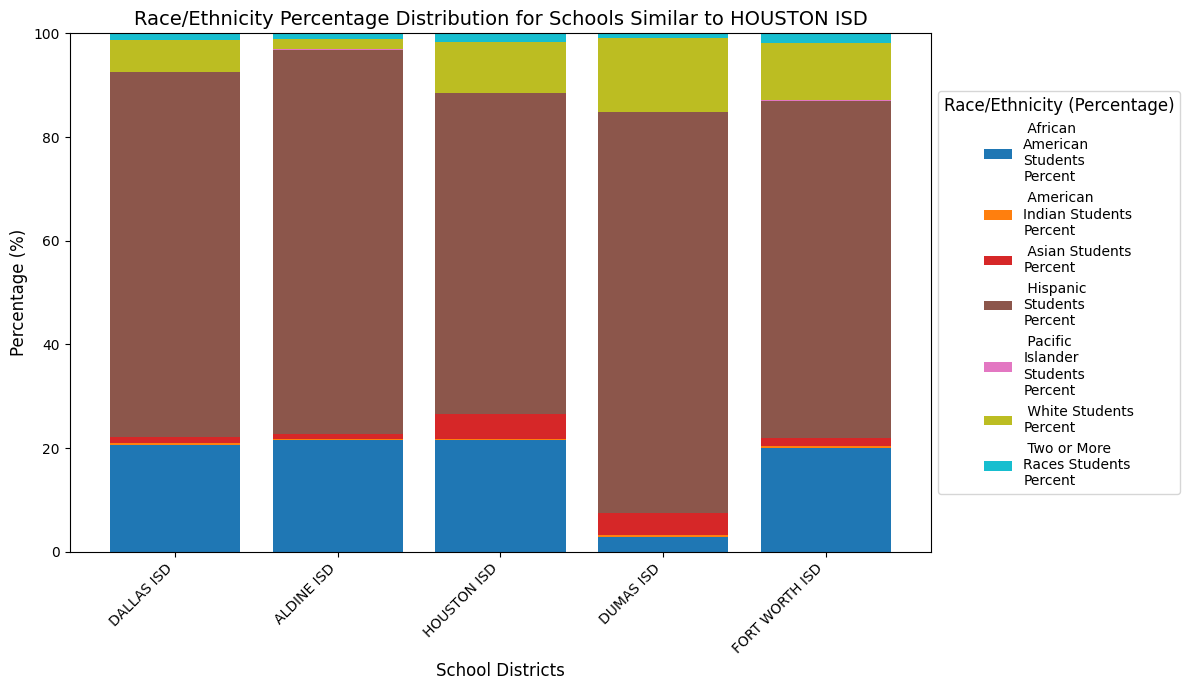

In [112]:
race_ethnicity_percent = [
    "District 2022-23 African American Students Percent",
    "District 2022-23 American Indian Students Percent",
    "District 2022-23 Asian Students Percent",
    "District 2022-23 Hispanic Students Percent",
    "District 2022-23 Pacific Islander Students Percent",
    "District 2022-23 White Students Percent",
    "District 2022-23 Two or More Races Students Percent"
]

def plot_race_ethnicity_stacked_bar(district_ids, df):
    """
    Visualizes race/ethnicity distribution as percentages using a stacked bar chart.

    Parameters:
    - district_ids (list): List of district IDs to visualize.
    - df (pd.DataFrame): DataFrame containing district race/ethnicity data.

    Returns:
    - A stacked bar chart comparing race/ethnicity distributions as percentages.
    """
    # Step0: Locate the Inputed District 
    input_dist = df[df["DISTRICT_id"] == district_ids[0]]['DISTNAME'].iloc[0]
    print((input_dist))
    
    # Step 1: Filter the DataFrame to include only selected districts
    selected_districts = df[df['DISTRICT_id'].isin(district_ids)][['DISTRICT_id', 'DISTNAME'] + race_ethnicity_percent]

    # Step 2: Check if any districts were found
    if selected_districts.empty:
        print("No matching districts found. Check the district IDs.")
        return

    # Step 3: Calculate total student count per district
    selected_districts["Total Students"] = selected_districts[race_ethnicity_percent].sum(axis=1)

    # Step 4: Convert race/ethnicity counts to percentages
    for col in race_ethnicity_percent:
        selected_districts[col] = (selected_districts[col] / selected_districts["Total Students"]) * 100

    # Step 5: Set the district names as index for plotting
    selected_districts.set_index("DISTNAME", inplace=True)

    # Step 6: Plot the stacked bar chart
    ax = selected_districts[race_ethnicity_percent].plot(
        kind='bar', 
        figsize=(12, 7), 
        stacked=True, 
        colormap="tab10",
        width=0.8
    )

    # Step 7: Formatting
    plt.title(f"Race/Ethnicity Percentage Distribution for Schools Similar to {input_dist}", fontsize=14)
    plt.xlabel("School Districts", fontsize=12)
    plt.ylabel("Percentage (%)", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 100)  # Ensure the y-axis represents 0% to 100%

    # Rename legend labels to reflect percentages instead of counts
    formatted_legend_labels = [
        label.replace("District 2022-23", "") for label in race_ethnicity_percent
    ]
    # Format legend with wrapped text to prevent it from being too large
    wrapped_labels = [textwrap.fill(label, width=15) for label in formatted_legend_labels]
    
    # Move legend to the right and wrap text for better readability
    ax.legend(wrapped_labels, title= f"Race/Ethnicity (Percentage)", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=10, title_fontsize=12)

    # Improve layout
    plt.tight_layout()
    plt.show()

plot_race_ethnicity_stacked_bar(knn, df)

Diagnostic Plot #3: Student to Teacher Ratio

In [18]:
# Define the relevant columns for teacher-student ratio
teacher_student_cols = [
    "District 2023 Staff: All Staff Total Full Time Equiv Count",
    "District 2023 Student Membership: All Students Count"
]

def create_teacher_student_ratio_table(district_ids, df):
    """
    Creates a table displaying the teacher-to-student ratio for selected school districts.

    Parameters:
    - district_ids (list): List of district IDs to include.
    - df (pd.DataFrame): DataFrame containing staff and student count data.

    Returns:
    - A DataFrame with the teacher-to-student ratio for each district.
    """
    
    # Step 1: Filter the DataFrame to include only selected districts and relevant columns
    selected_districts = df[df['DISTRICT_id'].isin(district_ids)][['DISTRICT_id', 'DISTNAME'] + teacher_student_cols]

    # Step 2: Check if any districts were found
    if selected_districts.empty:
        print("No matching districts found. Check the district IDs.")
        return

    # Step 3: Calculate the teacher-to-student ratio
    selected_districts["Total Staff-Student Ratio"] = (
        selected_districts["District 2023 Student Membership: All Students Count"] / 
        selected_districts["District 2023 Staff: All Staff Total Full Time Equiv Count"]
    )

    # Step 4: Select relevant columns for display
    selected_districts = selected_districts[["DISTNAME", "Total Staff-Student Ratio"]]

    # Display the table
    return selected_districts
# Function now generates and displays a table with the teacher-to-student ratio
create_teacher_student_ratio_table(closest_districts, clean_df)

,DISTNAME,Total Staff-Student Ratio
0,CAYUGA ISD,5.813725
224,DE LEON ISD,4.718499
877,HIGHLAND ISD,5.136364
953,WOODSBORO ISD,6.832000
988,SAN SABA ISD,5.089686


# Archive Code Used for Troubleshooting

In [19]:
merged_df = distgrad_clean.merge(distprof_clean, how = 'left', on = 'DISTRICT_id')

all_columns = list(merged_df.columns)
missing_col1 = set(class_size_teacher_ratio) - set(all_columns)

print("Total Columns Missing from merged dataset")
print(len(list(missing_col1)))

print("Total Columns coming from class_size_student_counts list")
print(len(list(set(class_size_student_counts)- set(all_columns))))

print("Total Columns coming from average_class_size list")
print(len(list(set(average_class_size) - set(all_columns))))


print("How many missing columns exist in distgrad? ")
print(len(list(set(missing_col1) - set(list(distgrad_clean.columns)))))

print("How many missing columns exist in distprof?")
print(len(list(set(missing_col1) - set(list(distprof_clean.columns)))))

#Conclusion: These 18 columns that are not being recognized come from both distgrad and distprof, when merging there must be some funky business 
print(missing_col1)


print((list(set(average_class_size) - set(all_columns))))
search_term = 'District 2023 Class Size: Sec Math'

real_val = [col for col in merged_df.columns if search_term in col]
print(real_val)

Total Columns Missing from merged dataset
0
Total Columns coming from class_size_student_counts list
0
Total Columns coming from average_class_size list
0
How many missing columns exist in distgrad? 
0
How many missing columns exist in distprof?
0
set()
[]
['District 2023 Class Size: Sec Math    - # Students', 'District 2023 Class Size: Sec Math    - # Classes', 'District 2023 Class Size: Sec Math    - Avg Size']


In [20]:
# Step 1: Select relevant feature buckets
selected_columns = student_demographics + class_size_teacher_ratio + staff_demographics

# Step 2: Filter dataset for selected features
#Get the intersection of selected_columns and existing columns in merged_df
existing_columns = [col for col in selected_columns if col in merged_df.columns]

# Select only available columns
knn_df = merged_df[["DISTRICT_id"] + existing_columns].copy()


# Step 3: Handle missing values (e.g., fill with median)
imputer = SimpleImputer(strategy="median")  # Change to 'mean' or 'most_frequent' if preferred
knn_df[selected_columns] = imputer.fit_transform(knn_df[selected_columns])

# Step 4: Normalize the feature set
scaler = StandardScaler()
knn_df[selected_columns] = scaler.fit_transform(knn_df[selected_columns])

# Step 5: Fit KNN model (excluding DISTRICT_id)
knn_model = NearestNeighbors(n_neighbors=5, metric="euclidean")  # Adjust neighbors as needed
knn_model.fit(knn_df[selected_columns])

# Step 6: Find the nearest neighbors for DISTRICT_id = 1902
query_point = knn_df[knn_df["DISTRICT_id"] == r"'001902"][selected_columns]
distances, indices = knn_model.kneighbors(query_point)

# Step 7: Get the closest districts
nearest_districts = clean_df.iloc[indices[0]]["DISTRICT_id"]

print("Top 5 closest districts to 1902:", nearest_districts.tolist())

Top 5 closest districts to 1902: [1902, 237904, 246908, 193902, 220907]


In [21]:
set((list(distprof_clean.columns)))




{'ASVAB_STATUS',
 'CNTYNAME',
 'COUNTY',
 'DFLALTED',
 'DFLCHART',
 'DISTNAME',
 'DISTRICT',
 'DISTRICT_id',
 'District 2022 DAEP: Count',
 'District 2022 DAEP: Percent',
 'District 2022 Finance: Instructional Expenditures Ratio',
 'District 2022 Graduates: African American Count',
 'District 2022 Graduates: African American Student Group %',
 'District 2022 Graduates: All Students Count (including FHSP)',
 'District 2022 Graduates: All Students Group %',
 'District 2022 Graduates: American Indian Count',
 'District 2022 Graduates: American Indian Student Group %',
 'District 2022 Graduates: Asian Count',
 'District 2022 Graduates: Asian Student Group %',
 'District 2022 Graduates: At Risk Count',
 'District 2022 Graduates: At Risk Student Group %',
 'District 2022 Graduates: EB/EL Count',
 'District 2022 Graduates: EB/EL Student Group %',
 'District 2022 Graduates: Econ Disadv Count',
 'District 2022 Graduates: Econ Disadv Student Group %',
 'District 2022 Graduates: FHSP No Endorseme

In [22]:

calculate_missing_percentage(distprof_clean)[0:30]


print(list(distprof_clean.columns))

['DISTRICT_id', 'District 2023 Class Size: Sec Soc Stud- # Students', 'District 2023 Class Size: Sec Soc Stud- # Classes', 'District 2023 Class Size: Sec Sci     - # Students', 'District 2023 Class Size: Sec Sci     - # Classes', 'District 2023 Class Size: Sec Math    - # Students', 'District 2023 Class Size: Sec Math    - # Classes', 'District 2023 Class Size: Grade 6     - # Students', 'District 2023 Class Size: Grade 6     - # Classes', 'District 2023 Class Size: Grade 5     - # Students', 'District 2023 Class Size: Grade 5     - # Classes', 'District 2023 Class Size: Grade 4     - # Students', 'District 2023 Class Size: Grade 4     - # Classes', 'District 2023 Class Size: Grade 3     - # Students', 'District 2023 Class Size: Grade 3     - # Classes', 'District 2023 Class Size: Grade 2     - # Students', 'District 2023 Class Size: Grade 2     - # Classes', 'District 2023 Class Size: Grade 1     - # Students', 'District 2023 Class Size: Grade 1     - # Classes', 'District 2023 Class 

In [ ]:
clean_df[clean_df['DISTNAME'] == 'HOUSTON ISD']
#101912

,DISTRICT_id,District 2022 Attendance: All Students Days Present,District 2022 Attendance: Two or More Races Days Present,District 2022 Attendance: African American Days Present,District 2022 Attendance: Hispanic Days Present,District 2022 Attendance: White Days Present,District 2022 Attendance: Econ Disadv Days Present,District 2022 Attendance: Special Ed Days Present,District 2022 Attendance: Female Days Present,District 2022 Attendance: Male Days Present,...,"District 2023 Domain 1A: Approaches Grade Level STD, Grade 8, Non-Continuous Enrollee, STAAR Science Rate","District 2023 Domain 1A: Meets Grade Level STD, Grade 8, Non-Continuous Enrollee, STAAR Science Rate","District 2023 Domain 1A: Masters Grade Level STD, Grade 8, Non-Continuous Enrollee, STAAR Science Rate",District,District Number,TEA District Type,TEA Description,NCES District Type,NCES Description,Charter School (Y/N)
532,101912,26460826.0,446967.5,5610907.0,16314033.5,2739260.5,20112525.5,2585175.0,13141663.5,13319162.5,...,57.0,26.0,7.0,HOUSTON ISD,101912,A,Major Urban,11,City-Large,N


https://chatgpt.com/share/67d1fd76-eccc-800d-806a-faf3e65c24f5

Better buckets TBH 